## Model Development & Performance

In [ ]:
import pandas as pd
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.ensemble import RandomForestRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

#### Data Loading

In [36]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

We will start with classic models to evaluate their effectiveness. As a first step, we will attempt to predict the number of people without power. Initially, we will remove columns that are not relevant to our task, such as time-related data and precise location identifiers (e.g., county name and code). The remaining data will be transformed and prepared for modeling.

### XGBRegressor

In [4]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind',]

In [5]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division']
event_features = [col for col in df.columns if col in event_names]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

event_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('event', event_transformer, event_features)
])

In [8]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

In [29]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    verbosity=1,
    colsample_bytree=0.3,
    early_stopping_rounds=20,
    random_state=42
)

xgb.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=True
)

[0]	validation_0-rmse:1479.44628
[1]	validation_0-rmse:1478.76089
[2]	validation_0-rmse:1478.22730
[3]	validation_0-rmse:1477.31792
[4]	validation_0-rmse:1476.28734
[5]	validation_0-rmse:1476.25554
[6]	validation_0-rmse:1474.07049
[7]	validation_0-rmse:1473.13567
[8]	validation_0-rmse:1472.70791
[9]	validation_0-rmse:1472.28972
[10]	validation_0-rmse:1471.00776
[11]	validation_0-rmse:1470.85316
[12]	validation_0-rmse:1469.18733
[13]	validation_0-rmse:1468.38280
[14]	validation_0-rmse:1468.30442
[15]	validation_0-rmse:1467.59923
[16]	validation_0-rmse:1465.09802
[17]	validation_0-rmse:1464.53772
[18]	validation_0-rmse:1464.02536
[19]	validation_0-rmse:1463.91608
[20]	validation_0-rmse:1463.74474
[21]	validation_0-rmse:1463.73358
[22]	validation_0-rmse:1462.90520
[23]	validation_0-rmse:1461.81601
[24]	validation_0-rmse:1461.37282
[25]	validation_0-rmse:1461.28740
[26]	validation_0-rmse:1461.27876
[27]	validation_0-rmse:1461.05672
[28]	validation_0-rmse:1461.04833
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [12]:
# Model XGBoost
xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=2
)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.001, 0.5),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

random_search.fit(X_train_proc, y_train)

with open("random_search_results.pkl", "wb") as f:
    pickle.dump(random_search, f)

print("✅ Zapisano RandomizedSearchCV do pliku random_search_results.pkl")
print("✅ Najlepsze parametry:", random_search.best_params_)
print("📉 Najlepszy neg-RMSE (cross-val):", random_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  54.1s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  49.4s
[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.4763571532049581, max_depth=5, n_estimators=171, subsample=0.8795975452591109; total time=  44.3s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  56.7s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417065; total time=  52.6s
[CV] END colsample_bytree=0.7468055921327309, learning_rate=0.07899726016810132, max_depth=5, n_estimators=187, subsample=0.8001125833417

In [15]:
best_model = random_search.best_estimator_
joblib.dump(best_model, "../models/xgb_model.pkl")
print("✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl")

✅ Zapisano najlepszy model XGBoost do best_xgb_model.pkl


In [19]:
y_pred = best_model.predict(X_val_proc)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 1414.8726
MAE: 91.6789
R²: 0.0882


As expected, the simplest model struggled to accurately estimate the target values, explaining only around 8% of the variance (R² = 0.0882). We are aware of the complexity and high noise level within the data, so such a result was anticipated. Moving forward, we will explore more advanced modeling approaches to improve performance.

### Time Series Modelling

Another model we are testing is the SARIMAX model, which is used for time series forecasting. It is particularly important as it allows us to account for both seasonal effects and exogenous variables. Since our data is aggregated on a daily basis, we can evaluate how well this model performs with such a frequency.

This model takes time as an input, but time is not unique in our dataset, since we are analyzing power outages separately for each county—this means that the same dates appear multiple times. The idea is to first test the model on five randomly selected counties to evaluate its performance.

In [258]:
random_counties = np.random.choice(df['CountyName'].unique(), size=5, replace=False).tolist()

In [274]:
df_dict = {}
for r in random_counties:
    df_subset = df[df['CountyName'] == r]
    state_random = np.random.choice(df_subset['StateName'].unique(), size=1)[0]
    df_subset = df_subset[df_subset['StateName'] == state_random]
    df_dict[r] = df_subset
    

We are now transforming or removing the following columns:

- FIPS, Month, Year, Region, Division, lng_rad, lat_rad, StateName, CountyName – these columns contain only one unique value per county and therefore do not add value for modeling.

- Month and Year – these will be removed since we will use the date column to model seasonality.

- ValidDataFlag 


The following transformations will be applied:

- season – this is a categorical variable and will be one-hot encoded into binary features.

Finally, we will sort the data by the date column and set it as the index of the DataFrame.

In [275]:
for key, d in df_dict.items():
    d = d.drop(columns=['Fips', 'Month', 'Year', 'Region', 'Division',
                          'lng_rad', 'lat_rad', 'StateName', 'CountyName', 'ValidDataFlag', 'CustomersOutEstimate'])

    d = pd.get_dummies(d, columns=['Season'])

    #d['Date'] = pd.to_date(d['Date'])
    df['Date'] = pd.to_datetime(df['Date'])
    d = d.sort_values('Date')
    d.set_index('Date', inplace=True)

    d = d.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


    df_dict[key] = d

Since we have two possible target columns (PercentCustomersOut and CustomersOut), we will compare the results obtained using each of them to evaluate which one yields better performance.

####  CustomersOut as prediction

In [276]:
import copy
dict_customers_out = copy.deepcopy(df_dict)

In [277]:
for key, d in dict_customers_out.items():
    d = d.drop(columns=['PercentCustomersOut'])
    dict_customers_out[key] = d

In [278]:
for key, d in dict_customers_out.items():
    print(len(d))

3393
3293
3287
3291
3287


We will split the DataFrame into training and testing sets. Since our goal is to make early predictions, we will use the most recent year (i.e., the last 365 days) as the test set.

In [279]:
for key, d in dict_customers_out.items():
    train = d.iloc[:-365]
    test = d.iloc[-365:]

    dict_customers_out[key] = [d, train, test]

The Augmented Dickey-Fuller (ADF) Test is a statistical test used to determine whether a time series is stationary or not. A stationary series has constant statistical properties such as mean, variance, and autocorrelation over time. The ADF test works by testing the null hypothesis that a unit root is present in the time series, which would imply the series is non-stationary (i.e., it has a trend or random walk behavior). If the test statistic is significantly negative and the p-value is low (usually less than 0.05), we reject the null hypothesis and conclude that the series is stationary.

In [280]:
for key, d in dict_customers_out.items():
    result = adfuller(d[1]['CustomersOut'])
    print('ADF Statistics for ' + key + ': ' + str(result[0]))
    print('p value for ' + key + ': ' + str(result[1]))
    print('------------------------------------------------')

ADF Statistics for Clinton: -44.55461654616125
p value for Clinton: 0.0
------------------------------------------------
ADF Statistics for Harris: -18.35053830348232
p value for Harris: 2.2369827069817784e-30
------------------------------------------------
ADF Statistics for Sawyer: -31.862051740802215
p value for Sawyer: 0.0
------------------------------------------------
ADF Statistics for Vermilion: -45.70890934788436
p value for Vermilion: 0.0
------------------------------------------------
ADF Statistics for Berks: -23.8565564079907
p value for Berks: 0.0
------------------------------------------------


#### Interpretation:

All p-values are smaller than 0.05, which means that for each of these counties, we can reject the null hypothesis of non-stationarity in the time series. Practically, this indicates that the data is stationary and can be used for analysis, modeling, and forecasting without the need for additional transformations such as removing trends or seasonality.



- All the values of the ADF test statistics are negative, which indicates that we can confidently reject the null hypothesis of non-stationarity. This strong negative result suggests that the time series for all counties is likely stationary, meaning there is no significant trend or unit root present.

### ACF and PACF Plots

**Purpose:**
- **ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)** plots are used to analyze the autocorrelations in a time series.
- ACF measures the correlation between a time series and its lagged values over different periods.
- PACF shows the partial correlation, which measures the correlation between the series and its lag, after removing the effects of shorter lags.

- **ACF Plot:** If the ACF shows a sharp cutoff, it suggests an MA process of a certain order.
- **PACF Plot:** A sharp cutoff in the PACF plot indicates the order of the AR component.


In [281]:
def plot_acf_pacf(dict, lag, col='CustomersOut'):
    plt.figure(figsize=(14, 10))

    for i, (key, d) in enumerate(dict.items(), 1):
        train = d[1]
        plt.subplot(5, 2, 2 * i - 1) 
        plot_acf(train[col], lags=lag, ax=plt.gca())
        plt.title(f"ACF - {key}")

        plt.subplot(5, 2, 2 * i) 
        plot_pacf(train[col], lags=lag, ax=plt.gca(), method='ywm')
        plt.title(f"PACF - {key}")

    plt.tight_layout()
    plt.show()


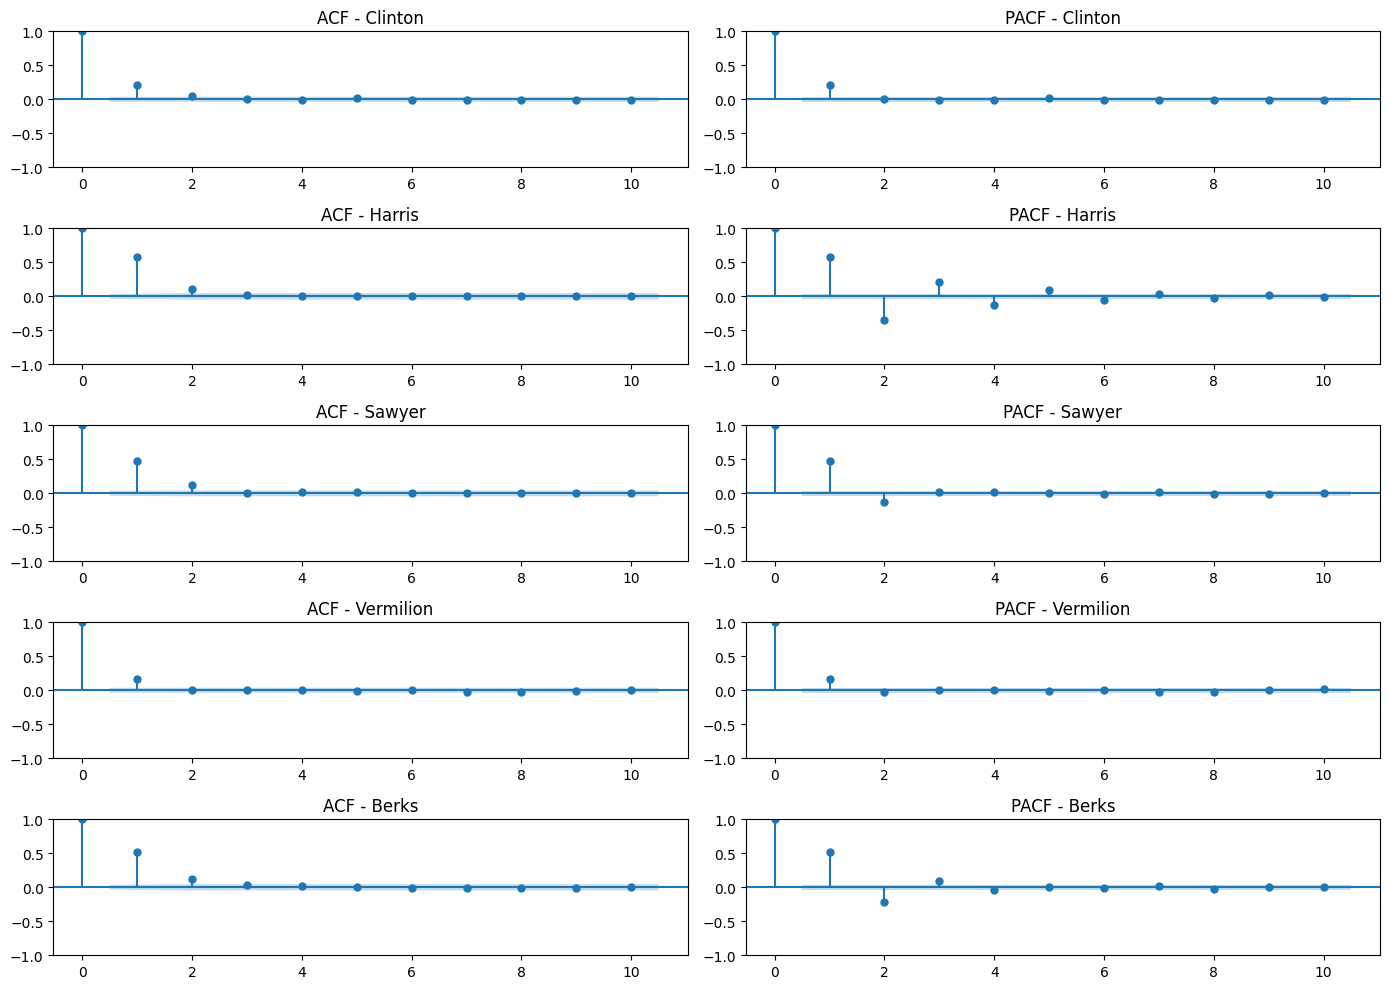

In [282]:
plot_acf_pacf(dict_customers_out, 10)

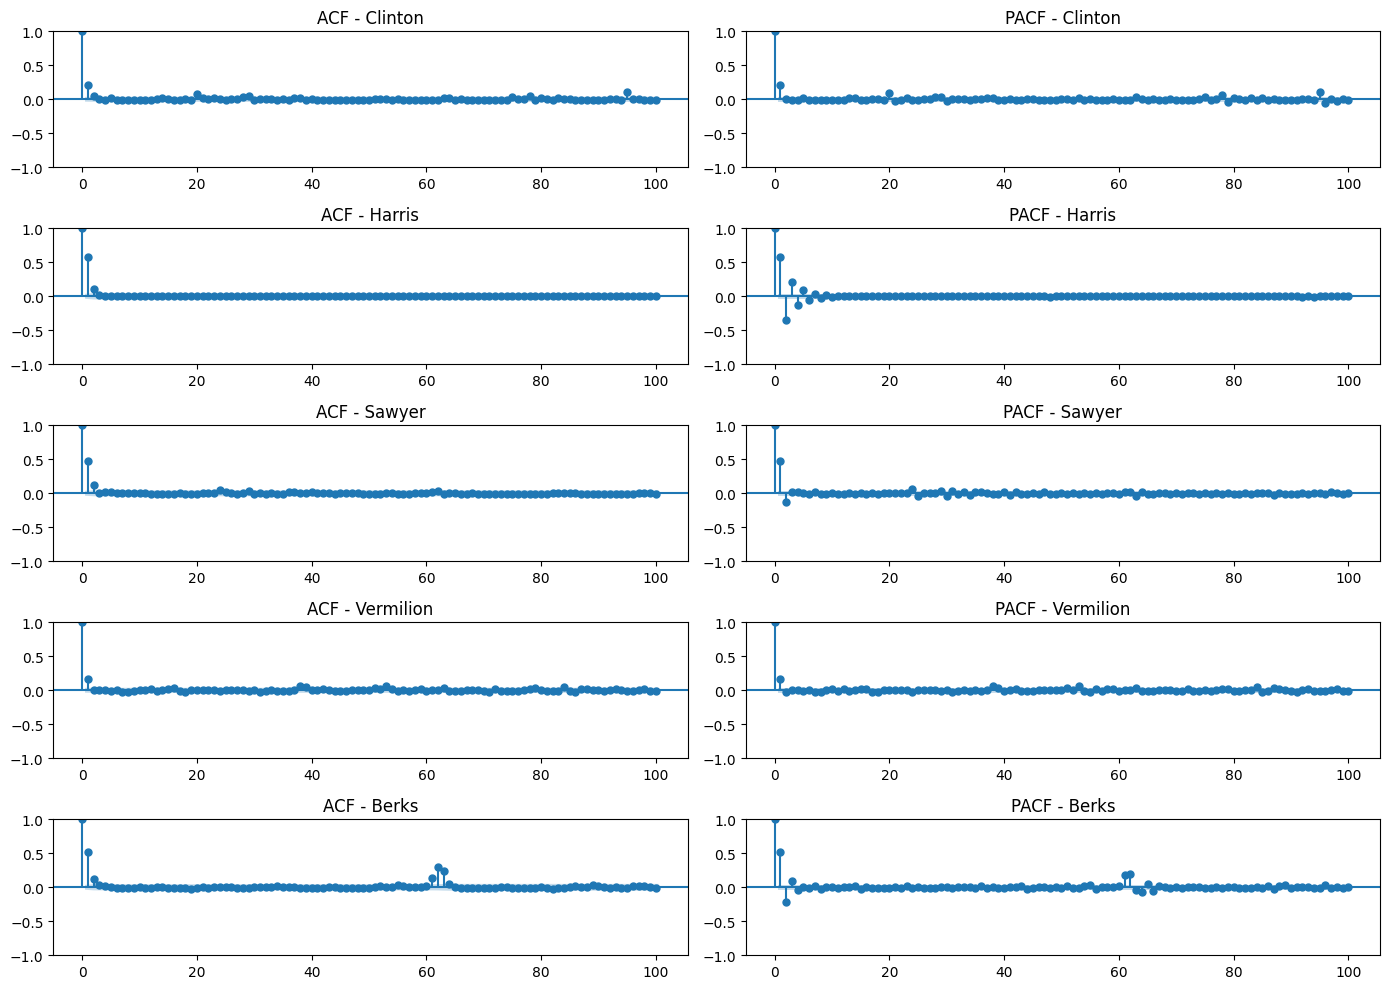

In [283]:
plot_acf_pacf(dict_customers_out, 100)

- In this case, for all counties, the ACF plots show a sharp drop after a few lags. This suggests that most of the correlation in the series is captured by the initial few lags. After that, the correlation quickly diminishes, indicating short-range dependence
- the series has little memory
- PACF has a significant peak at lag 1, suggesting that an AR(1) process might also be a reasonable starting point for these counties

In [284]:
q = 1
p = 1
dd = 0  ## dane stacjonarne

In [285]:
for key, d in dict_customers_out.items():
    train = d[1]
    test = d[2]
    test = test[~test.index.duplicated()]
    train = train[~train.index.duplicated()]

    print(train.index[-1])

    model = SARIMAX(
    train['CustomersOut'],
    exog=train.drop(columns='CustomersOut'),
    order=(p, dd, q), 
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
    )

    results = model.fit()
    forecast = results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='CustomersOut'))

    dict_customers_out[key].append(results)
    dict_customers_out[key].append(forecast)



2023-01-15 00:00:00
2022-12-31 00:00:00
2022-12-31 00:00:00
2022-12-31 00:00:00
2022-12-31 00:00:00


In [286]:
dict_customers_out['Clinton'][3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CustomersOut   No. Observations:                 2937
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -17245.541
Date:                Sat, 19 Apr 2025   AIC                          34589.082
Time:                        14:20:08   BIC                          34882.320
Sample:                    01-01-2015   HQIC                         34694.676
                         - 01-15-2023                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Astronomical Low Tide   -3.423e-07         -0        inf      0.000   -3.42e-07   -3.42e-07
Extreme Cold/Wind Chill    35.7609     85.817      0.417      0.677    -132.438     203.959
Flood                      -1.4695     44.952     -0.033      0.974     -89.573      86.634
Winter Weather             -4.2256    151.482     -0.028      0.978    -301.124     292.673
TotalDamages            -2.461e-05   2.99e-05     -0.824      0.410   -8.31e-05    3.39e-05
Wildfire                -6.209e-09   6.57e-08     -0.094      0.925   -1.35e-07    1.23e-07
Heavy Rain                 -4.6117      0.049    -93.651      0.000      -4.708      -4.515
Cold/Wind Chill         -2.585e-09        nan        nan        nan         nan         nan
Dense Fog               -9.074e-10        nan        nan        nan         nan         nan
Frost/Freeze               -5.8654      1.148     -5.109      0.000      -8.116      -3.615
Strong Wind                -0.8450    226.788     -0.004      0.997    -445.341     443.651
Lake-Effect Snow        -1.854e-10        nan        nan        nan         nan         nan
Funnel Cloud               -5.5211    545.399     -0.010      0.992   -1074.483    1063.441
Flash Flood                -5.1864     21.415     -0.242      0.809     -47.158      36.786
Heavy Snow                 -2.7002    290.203     -0.009      0.993    -571.488     566.088
Ice Storm                  -3.6812    124.295     -0.030      0.976    -247.295     239.933
Thunderstorm Wind           2.9915      4.035      0.741      0.458      -4.916      10.900
Avalanche                1.048e-11   1.13e-12      9.267      0.000    8.26e-12    1.27e-11
Excessive Heat             17.2481     33.422      0.516      0.606     -48.257      82.753
Coastal Flood            8.388e-12        nan        nan        nan         nan         nan
Storm Surge/Tide         1.355e-11   5.58e-13     24.282      0.000    1.25e-11    1.46e-11
Sleet                      -6.3395     79.540     -0.080      0.936    -162.235     149.556
Debris Flow             -8.369e-12        nan        nan        nan         nan         nan
Winter Storm               37.7018      9.647      3.908      0.000      18.795      56.609
TotalPeopleInjuries       -11.7556     39.378     -0.299      0.765     -88.935      65.424
Magnitude                  -2.2872      4.044     -0.566      0.572     -10.213       5.639
Tropical Storm           6.401e-11        nan        nan        nan         nan         nan
Dust Storm               1.419e-10        nan        nan        nan         nan         nan
Drought                     4.4150     70.747      0.062      0.950    -134.246     143.076
Blizzard                   72.7777    104.225      0.698      0.485    -131.500     277.055
Lightning               -7.316e-14   7.93e-14     -0.922      0.356   -2.29e-13    8.23e-14
Tornado                    -4.2241     10.589     -0.399      0.690     -24.978      16.530
Hail                 

In [289]:
def plot_forecasts(data_dict, col='CustomersOut', maxlim=5000):

    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
    fig.subplots_adjust(hspace=0.4)
    
    for ax, (key, d) in zip(axes, data_dict.items()):
        train = d[1]
        test = d[2]
        forecast = d[4]
        test = test[~test.index.duplicated()]
        train = train[~train.index.duplicated()]
        
        ax.plot(train.index, train[col], label='Trening', color='blue')
        ax.plot(test.index, test[col], label='Rzeczywiste dane', color='green')
        ax.plot(test.index, forecast, label='Prognozy', color='red', alpha=0.5)
        ax.set_title(f'Wykres: {key}')
        ax.set_ylim(0, maxlim)
        ax.legend()

    plt.xlabel("Data")
    plt.tight_layout()
    plt.show()


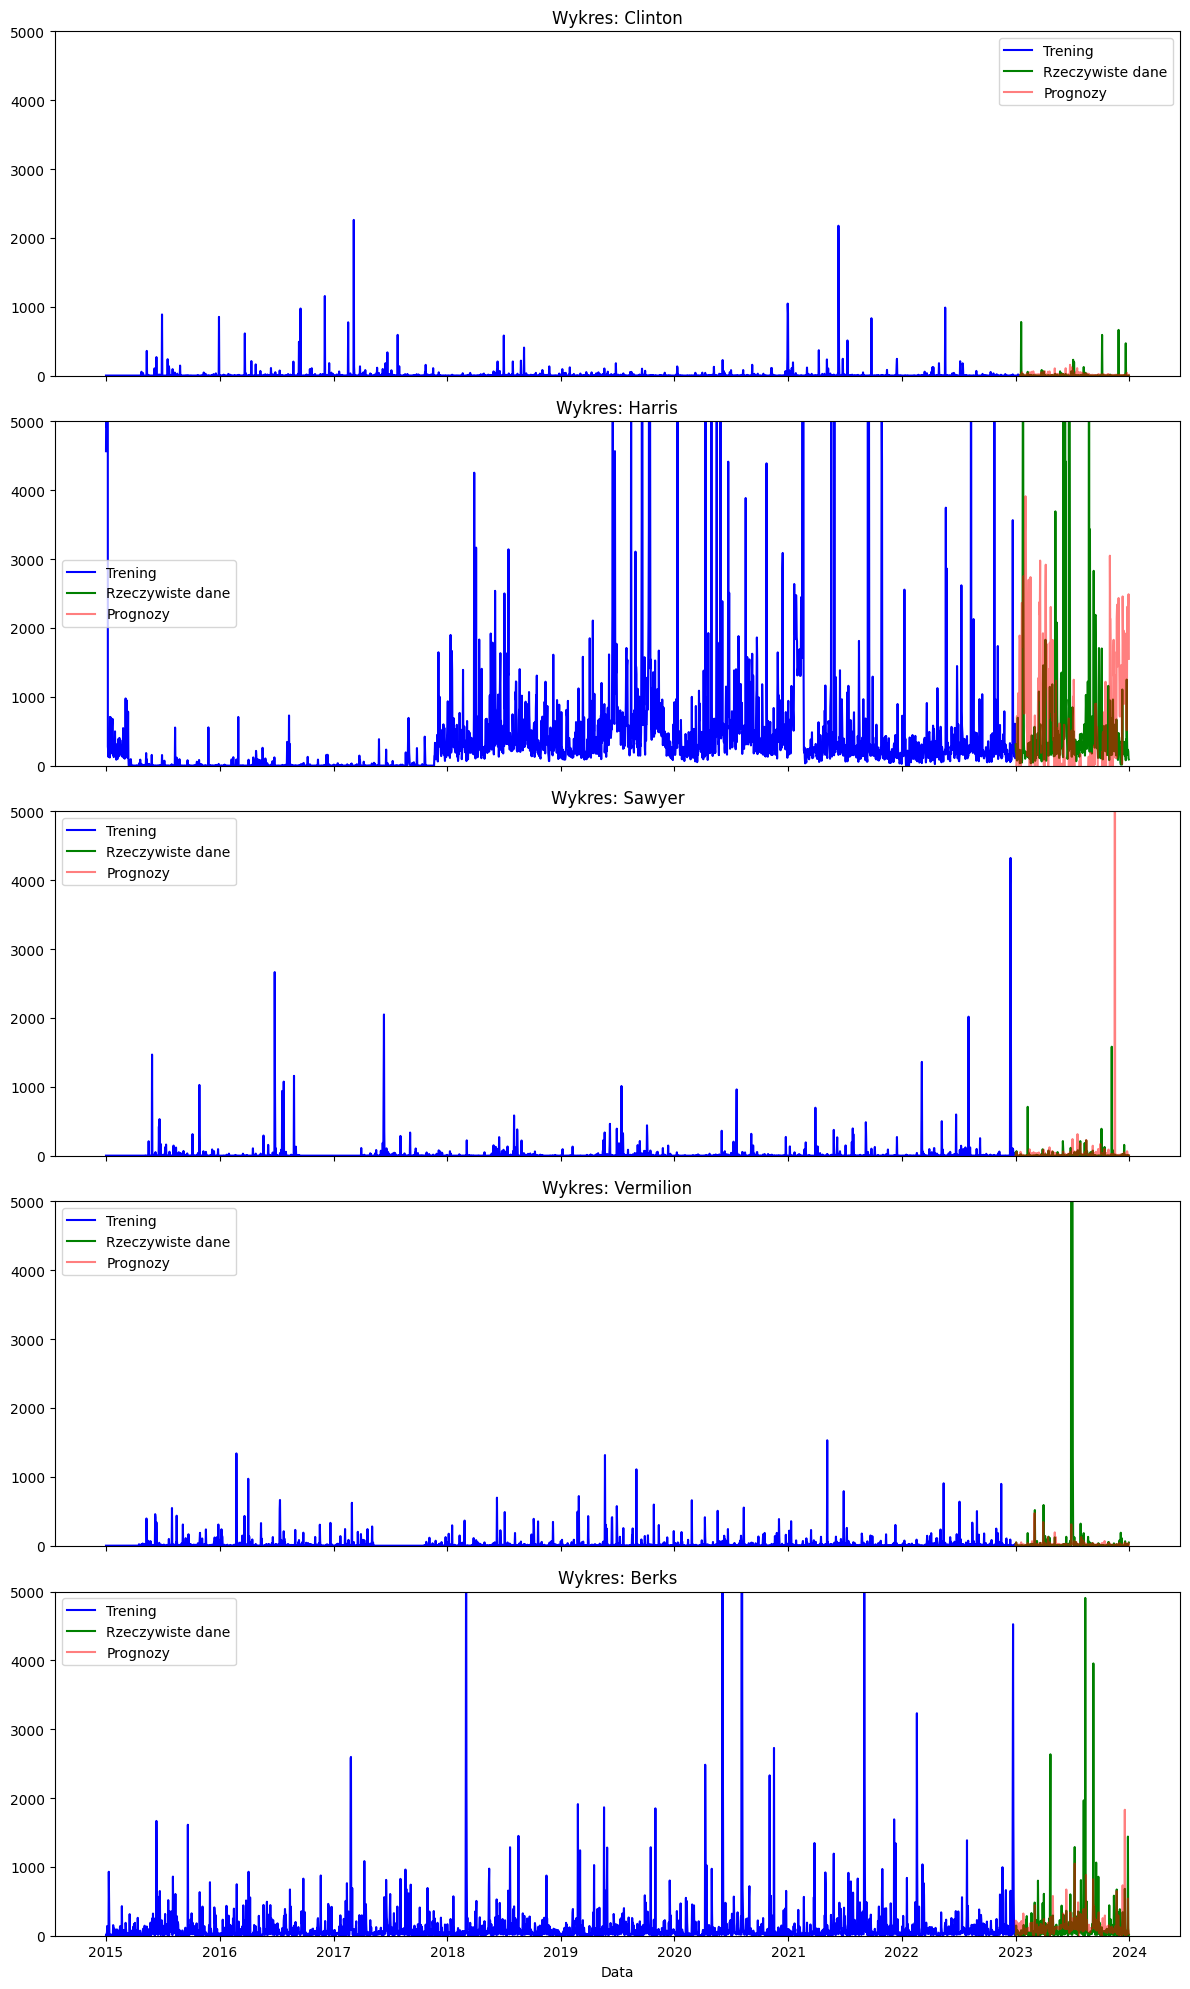

In [290]:
plot_forecasts(dict_customers_out)

In [291]:
def evaluate_forecasts(data_dict, col='CustomersOut'):
    results = []

    for key, d in data_dict.items():
        test = d[2]
        forecast = d[4]

        test = test[~test.index.duplicated()]
        forecast = forecast[~forecast.index.duplicated()]

        y_true = test.loc[forecast.index, col]
        y_pred = forecast

        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        results.append({
            '  ': key,
            'MAE': round(mae, 2),
            'MSE': round(mse, 2),
            'R²': round(r2, 4)
        })

    return pd.DataFrame(results)

In [292]:
evaluation = evaluate_forecasts(dict_customers_out)

In [293]:
evaluation

,,MAE,MSE,R²
0,Clinton,21.24,5201.83,-0.0679
1,Harris,1224.26,8558289.46,-0.2044
2,Sawyer,63.34,466214.11,-48.8682
3,Vermilion,196.98,2630854.59,-0.0032
4,Berks,140.50,152555.73,0.0924


#### PercentCustomersOut as prediction

In [294]:
dict_percent = copy.deepcopy(df_dict)

In [295]:
for key, d in dict_percent.items():
    d = d.drop(columns=['CustomersOut'])
    dict_percent[key] = d

In [296]:
for key, d in dict_percent.items():
    train = d.iloc[:-365]
    test = d.iloc[-365:]

    dict_percent[key] = [d, train, test]

In [297]:
for key, d in dict_percent.items():
    result = adfuller(d[1]['PercentCustomersOut'])
    print('ADF Statistics for ' + key + ': ' + str(result[0]))
    print('p value for ' + key + ': ' + str(result[1]))
    print('------------------------------------------------')

ADF Statistics for Clinton: -44.55461654616124
p value for Clinton: 0.0
------------------------------------------------
ADF Statistics for Harris: -18.3505383034823
p value for Harris: 2.2369827069817143e-30
------------------------------------------------
ADF Statistics for Sawyer: -31.862051740802237
p value for Sawyer: 0.0
------------------------------------------------
ADF Statistics for Vermilion: -45.708909347884344
p value for Vermilion: 0.0
------------------------------------------------
ADF Statistics for Berks: -23.856556407990677
p value for Berks: 0.0
------------------------------------------------


All p-values are below 0.05, allowing us to reject the null hypothesis of non-stationarity. This means the data is stationary and can be used for analysis, modeling, and forecasting without further transformations like removing trends or seasonality.



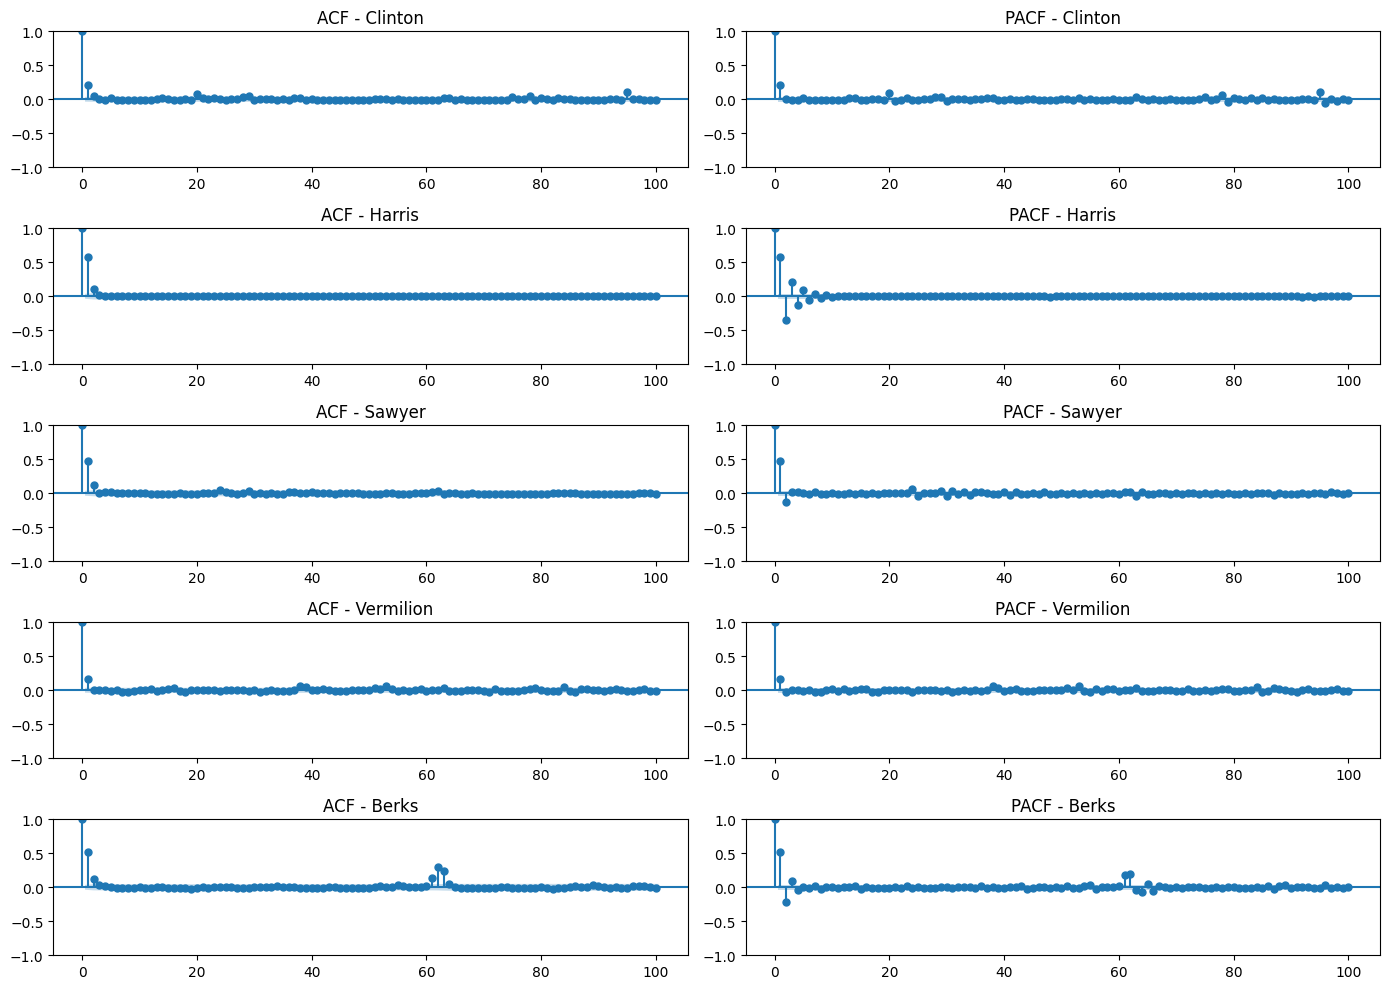

In [298]:
plot_acf_pacf(dict_percent, 100, 'PercentCustomersOut')

In [299]:
for key, d in dict_percent.items():
    train = d[1]
    test = d[2]
    test = test[~test.index.duplicated()]
    train = train[~train.index.duplicated()]

    model = SARIMAX(
        train['PercentCustomersOut'],
        exog=train.drop(columns='PercentCustomersOut'),
        order=(p, dd, q), 
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit()
    forecast = results.predict(start=test.index[0], end=test.index[-1], exog=test.drop(columns='PercentCustomersOut'))

    dict_percent[key].append(results)
    dict_percent[key].append(forecast)



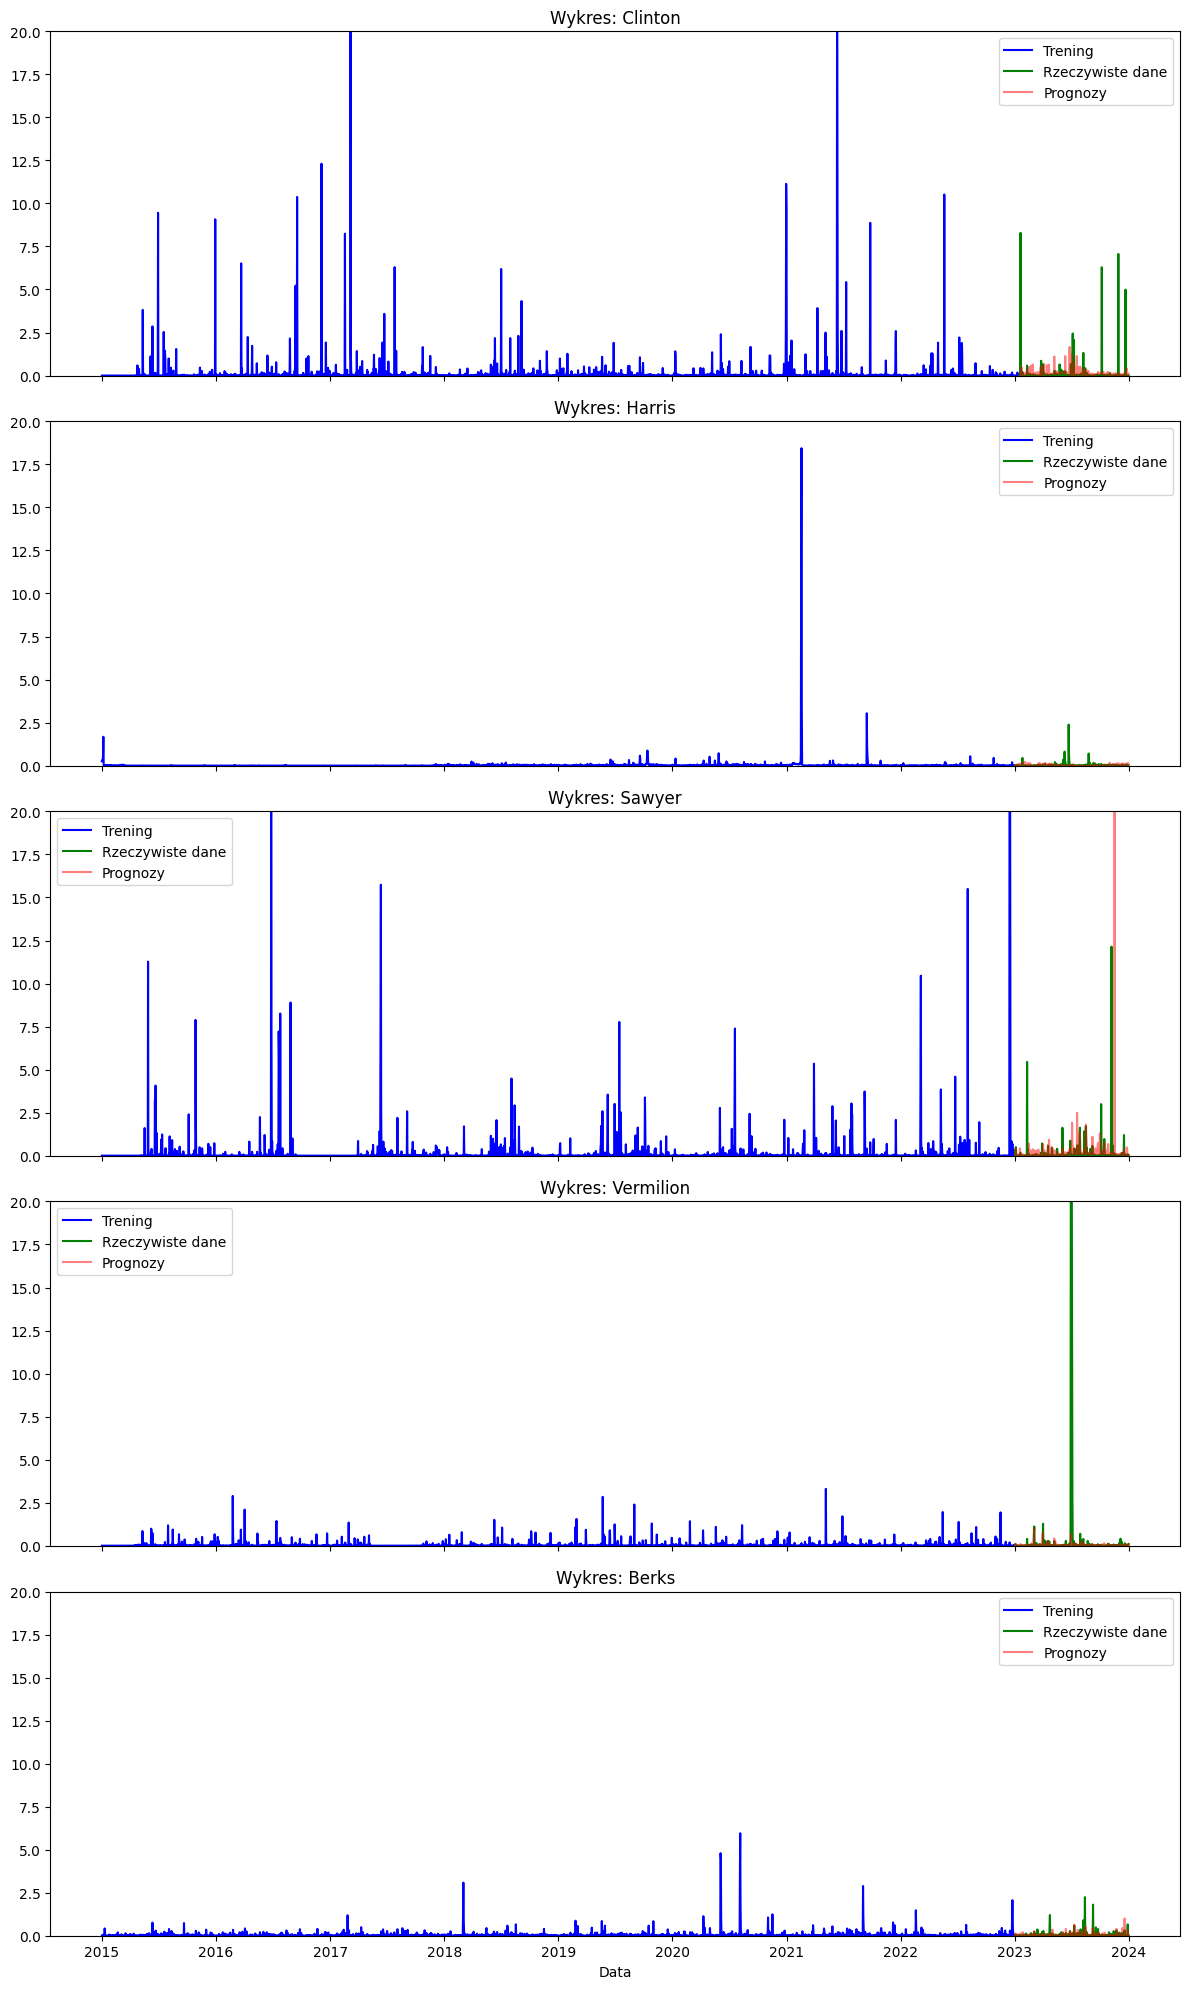

In [300]:
plot_forecasts(dict_percent, col='PercentCustomersOut', maxlim=20)

In [301]:
evaluate_forecasts(dict_percent, 'PercentCustomersOut')

,,MAE,MSE,R²
0,Clinton,0.23,0.60,-0.0792
1,Harris,0.07,0.03,-0.2044
2,Sawyer,0.49,27.53,-48.9433
3,Vermilion,0.42,12.23,-0.0032
4,Berks,0.06,0.03,0.0818


### TabNet

In [37]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

In [38]:
df.shape

(8323937, 57)

Due to the high computational demands of TabNet, we had to limit both the dataset size and adjust the network parameters. We are using only the rows that we previously identified as "trustworthy" during the feature engineering stage, and we are selecting weather event columns that are expected to contribute the most valuable information.

In [39]:
df = df[df['ValidDataFlag'] == 1]
df.shape

(3240255, 57)

In [53]:
df['Year'].value_counts()
df = df[~df['Year'].isin([2015, 2016, 2017])]
df.shape

(2701153, 57)

In [49]:
zero_percentages = {}

for col in event_names:
    if col in df.columns:
        zero_count = (df[col] == 0).sum()
        total_count = len(df)
        zero_percentage = (zero_count / total_count) * 100
        zero_percentages[col] = zero_percentage

zero_percentages_df = pd.DataFrame.from_dict(zero_percentages, orient='index', columns=['%_zero'])
zero_percentages_df = zero_percentages_df.sort_values('%_zero', ascending=False)

display(zero_percentages_df)

,%_zero
High Surf,99.999593
Avalanche,99.999297
Freezing Fog,99.996557
Dust Storm,99.996298
Rip Current,99.995113
Storm Surge/Tide,99.993632
Sleet,99.987709
Astronomical Low Tide,99.987413
Lake-Effect Snow,99.978750
Debris Flow,99.978046


In [50]:
selected_events_name = [
    col for col, perc in zero_percentages.items() if perc < 99.8
]

print(selected_events_name)

['Flood', 'Winter Weather', 'Heavy Rain', 'Strong Wind', 'Flash Flood', 'Heavy Snow', 'Thunderstorm Wind', 'Excessive Heat', 'Winter Storm', 'Drought', 'Tornado', 'Hail', 'Heat', 'High Wind']


In [51]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'StateName', 'CountyName']
event_features = [col for col in df.columns if col in selected_events_name]

X = df[numeric_features + categorical_features + event_features]
y = df[target]

In [52]:
X.shape, y.shape

((2701153, 26), (2701153,))

In [54]:
X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [ ]:
model_TabNet = TabNetRegressor(
    n_d=16,            
    n_a=16,
    n_steps=3,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [58]:
model_TabNet.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_test.values, y_test.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=10,
    patience=4,
    batch_size=4096,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 3460273.93356| val_0_rmse: 1954.44042|  0:05:42s
epoch 1  | loss: 3445467.56533| val_0_rmse: 1950.2747|  0:15:46s
epoch 2  | loss: 3447512.20995| val_0_rmse: 1950.97798|  0:25:46s
epoch 3  | loss: 3433010.06952| val_0_rmse: 1947.5803|  0:35:15s
epoch 4  | loss: 3416002.92128| val_0_rmse: 1935.06165|  0:44:11s
epoch 5  | loss: 3392685.07911| val_0_rmse: 1921.98469|  0:53:11s
epoch 6  | loss: 3376295.85399| val_0_rmse: 1932.97782|  1:02:50s
epoch 7  | loss: 3355619.75473| val_0_rmse: 1922.84166|  1:13:28s
epoch 8  | loss: 3345976.31067| val_0_rmse: 1920.99402|  1:24:14s
epoch 9  | loss: 3335282.37767| val_0_rmse: 1917.46909|  1:34:50s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_0_rmse = 1917.46909


In [59]:
model_TabNet.save_model('../models/tabnet_model')

Successfully saved model at ../models/tabnet_model.zip


'../models/tabnet_model.zip'

In [60]:
y_pred = model_TabNet.predict(X_test.values).flatten()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MSE: 3676687.7208
RMSE: 1917.4691
R²: 0.0431


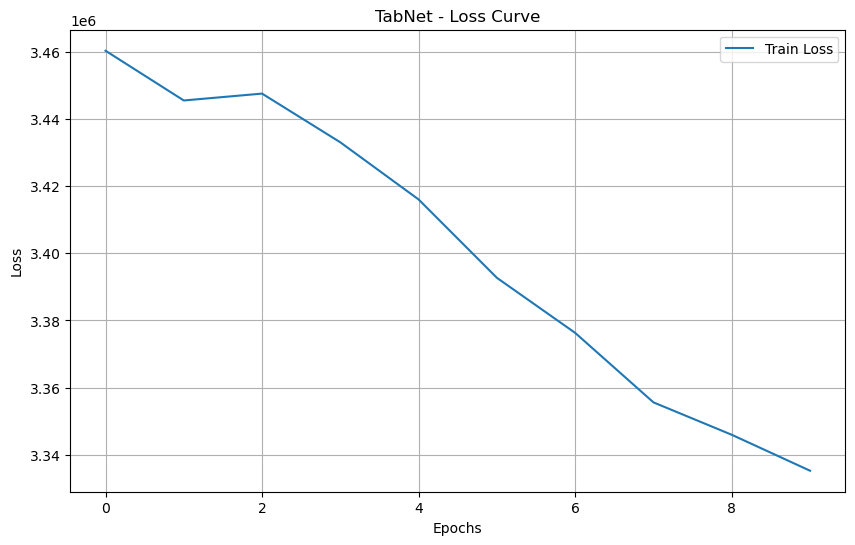

In [89]:
train_loss = model_TabNet.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TabNet - Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


Longer training

We will attempt to train the TabNet model again. Although the previous training did not yield the best results, we observed a very promising decrease in both loss and RMSE. We assume that a longer training process may help us achieve a better outcome. We are adjusting the training duration and diversifying the model architecture (while, of course, taking into account our computational limitations).

In [79]:
sample_frac = 0.1

sample_idx = np.random.choice(len(X_train), int(len(X_train) * sample_frac), replace=False)
X_sample = X_train.iloc[sample_idx]
y_sample = y_train.iloc[sample_idx]

X_train_small, X_val_small, y_train_small, y_val_small = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42
)

In [83]:
param_grid = {
    'n_d': [16, 32],
    'n_a': [16, 32],
    'n_steps': [3, 5, 7],
    'gamma': [1.0, 1.5]
}

grid = list(product(*param_grid.values()))

In [81]:
def train_and_evaluate(X_train, y_train, X_val, y_val, params):
    model = TabNetRegressor(
        n_d=params['n_d'],
        n_a=params['n_a'],
        n_steps=params['n_steps'],
        gamma=params['gamma'],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        verbose=1
    )
    model.fit(
        X_train=X_train.values,
        y_train=y_train.values.reshape(-1,1),
        eval_set=[(X_val.values, y_val.values.reshape(-1,1))],
        eval_metric=["rmse"],
        max_epochs=10,
        patience=3,
        batch_size=4096,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    preds = model.predict(X_val.values)
    rmse = mean_squared_error(y_val.values, preds, squared=False)
    return rmse

In [84]:
best_rmse = float('inf')
best_params = None

for values in grid:
    params = dict(zip(param_grid.keys(), values))
    print(f"Testing params: {params}")
    rmse = train_and_evaluate(X_train_small, y_train_small, X_val_small, y_val_small, params)
    print(f"RMSE: {rmse:.4f}")
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("\nBest parameters found:")
print(best_params)
print(f"Best RMSE: {best_rmse:.4f}")

Testing params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.0}
epoch 0  | loss: 5472017.01989| val_0_rmse: 1581.56013|  0:00:40s
epoch 1  | loss: 5459390.40923| val_0_rmse: 1578.76356|  0:01:20s
epoch 2  | loss: 5450004.98245| val_0_rmse: 1579.36811|  0:01:56s
epoch 3  | loss: 5451716.98474| val_0_rmse: 1579.21782|  0:02:41s
epoch 4  | loss: 5449016.93197| val_0_rmse: 1578.61006|  0:03:27s
epoch 5  | loss: 5445539.40371| val_0_rmse: 1578.96193|  0:04:10s
epoch 6  | loss: 5443686.91298| val_0_rmse: 1577.58561|  0:04:54s
epoch 7  | loss: 5443509.16332| val_0_rmse: 1577.62899|  0:05:25s
epoch 8  | loss: 5440775.93659| val_0_rmse: 1578.31661|  0:05:53s
epoch 9  | loss: 5441087.69912| val_0_rmse: 1577.92144|  0:06:32s

Early stopping occurred at epoch 9 with best_epoch = 6 and best_val_0_rmse = 1577.58561
RMSE: 1577.5856
Testing params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.5}
epoch 0  | loss: 5472048.17123| val_0_rmse: 1581.83487|  0:00:32s
epoch 1  | loss: 5457123.39279| val

In [86]:
model_TabNet_v2 = TabNetRegressor(
    n_d=32,            
    n_a=16,
    n_steps=3,
    gamma=1.0,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [87]:
model_TabNet_v2.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_train.values, y_train.values.reshape(-1,1)), 
     (X_test.values, y_test.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=4096,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 3457134.58037| val_0_rmse: 1857.26878| val_1_rmse: 1954.11536|  0:08:07s
epoch 1  | loss: 3447152.21128| val_0_rmse: 1853.31924| val_1_rmse: 1951.50246|  0:16:20s
epoch 2  | loss: 3438057.87929| val_0_rmse: 1849.97826| val_1_rmse: 1949.61545|  0:24:53s
epoch 3  | loss: 3434242.24095| val_0_rmse: 1851.74996| val_1_rmse: 1951.19503|  0:31:47s
epoch 4  | loss: 3427520.29119| val_0_rmse: 1843.51151| val_1_rmse: 1944.33749|  0:38:41s
epoch 5  | loss: 3429580.06117| val_0_rmse: 1851.02653| val_1_rmse: 1949.44956|  0:45:29s
epoch 6  | loss: 3428040.339| val_0_rmse: 1843.54925| val_1_rmse: 1943.58258|  0:52:17s
epoch 7  | loss: 3416243.91239| val_0_rmse: 1844.91138| val_1_rmse: 1945.73315|  0:59:05s
epoch 8  | loss: 3415560.75856| val_0_rmse: 1842.79327| val_1_rmse: 1943.17584|  1:05:49s
epoch 9  | loss: 3418547.12863| val_0_rmse: 1842.08184| val_1_rmse: 1944.80513|  1:17:06s
epoch 10 | loss: 3413026.7347| val_0_rmse: 1840.89688| val_1_rmse: 1940.56171|  1:25:43s
epoch 11 | lo

In [88]:
model_TabNet_v2.save_model('../models/tabnet_model_v2')

Successfully saved model at ../models/tabnet_model_v2.zip


'../models/tabnet_model_v2.zip'

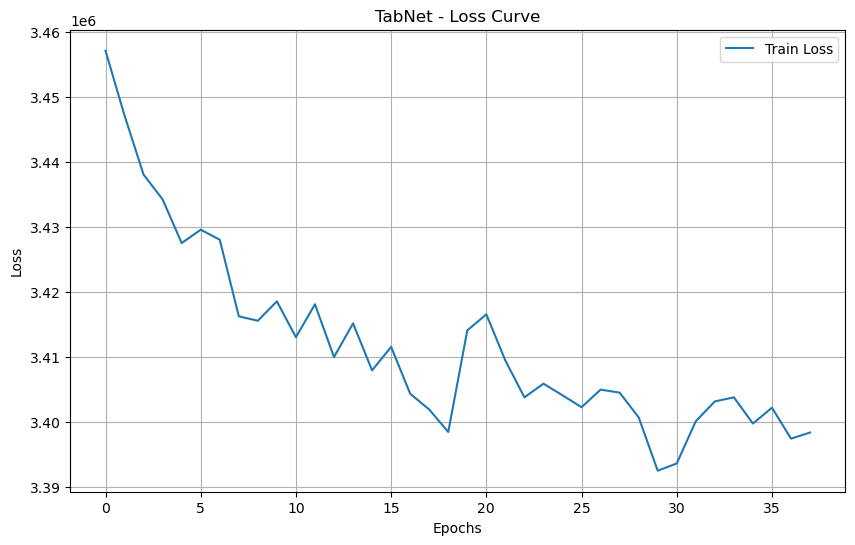

In [93]:
train_loss = model_TabNet_v2.history['loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TabNet - Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

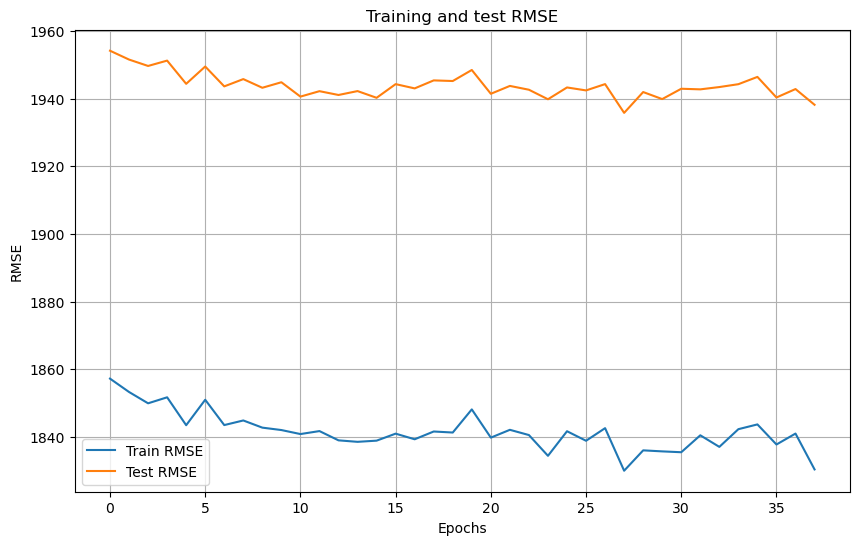

In [94]:
train_rmse = model_TabNet_v2.history['val_0_rmse']
test_rmse = model_TabNet_v2.history['val_1_rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(test_rmse, label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training and test RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
y_pred_train = model_TabNet_v2.predict(X_train.values).flatten()
y_pred_test = model_TabNet_v2.predict(X_test.values).flatten()

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'RMSE on train: {train_rmse[-1]:6f}')
print(f'RMSE on test: {test_rmse[-1]:6f}')

print(f'R^2 on train: {r2_train:6f}')
print(f'R^2 on test: {r2_test:6f}')

RMSE on train: 1830.451422
RMSE on test: 1938.148024
R^2 on train: 0.035120
R^2 on test: 0.024777


Our assumptions have been confirmed — it is particularly noticeable during the initial phases of training that the loss consistently decreases after applying a more complex architecture and extending the training duration. However, the model still achieves relatively high RMSE values.

It is important to note that these results are aggregated across the entire country. In the following sections, we will take a closer look at the performance across individual states, which will reveal that there are counties where the model performs significantly better. We will further analyze these states to investigate why the model achieves more favorable results in those specific areas.

### TabNet for State-Specific

In [100]:
df = pd.read_csv('../data/modelingData/modelingDataFrame.csv')

In [104]:
df_wyoming = df[df['StateName'] == 'Wyoming']

In [106]:
event_names = ['Astronomical Low Tide', 'Extreme Cold/Wind Chill', 'Flood','Winter Weather', 
               'Wildfire', 'Heavy Rain', 'Cold/Wind Chill', 'Dense Fog', 'Frost/Freeze', 'Strong Wind',
               'Lake-Effect Snow', 'Funnel Cloud', 'Flash Flood', 'Heavy Snow', 'Ice Storm', 
               'Thunderstorm Wind', 'Avalanche', 'Excessive Heat', 'Coastal Flood', 'Storm Surge/Tide', 
               'Sleet', 'Debris Flow', 'Winter Storm', 'Tropical Storm', 'Dust Storm', 'Drought', 
               'Blizzard', 'Lightning', 'Tornado', 'Hail', 'Rip Current', 'Heat', 'Freezing Fog', 
               'High Surf', 'High Wind']

In [ ]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'StateName', 'CountyName']
event_features = [col for col in df_wyoming.columns if col in selected_events_name]

X = df_wyoming[numeric_features + categorical_features + event_features]
y = df_wyoming[target]

X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

In [145]:
Q3 = np.percentile(y, 90)
Q1 = np.percentile(y, 10)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

print(f"Before: {len(y)}")
print(f"After: {len(y_no_outliers)}")


Before: 45482
After: 42610


In [142]:
X_train_wyoming, X_test_wyoming, y_train_wyoming, y_test_wyoming = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [143]:
model_TabNet_wyoming = TabNetRegressor(
    n_d=64,            
    n_a=64,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,    
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [144]:
model_TabNet_wyoming.fit(
    X_train=X_train_wyoming.values,
    y_train=y_train_wyoming.values.reshape(-1,1),
    eval_set=[(X_train_wyoming.values, y_train_wyoming.values.reshape(-1,1)), 
     (X_test_wyoming.values, y_test_wyoming.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True
)

epoch 0  | loss: 66.08775| val_0_rmse: 9.65255 | val_1_rmse: 9.90274 |  0:00:21s
epoch 1  | loss: 44.90058| val_0_rmse: 8.20171 | val_1_rmse: 8.2308  |  0:00:49s
epoch 2  | loss: 36.77623| val_0_rmse: 6.36563 | val_1_rmse: 6.28643 |  0:01:24s
epoch 3  | loss: 34.17688| val_0_rmse: 5.90751 | val_1_rmse: 5.83339 |  0:02:12s
epoch 4  | loss: 32.74263| val_0_rmse: 5.95629 | val_1_rmse: 6.18011 |  0:03:01s
epoch 5  | loss: 31.84185| val_0_rmse: 5.78111 | val_1_rmse: 5.8203  |  0:03:48s
epoch 6  | loss: 30.98863| val_0_rmse: 5.59607 | val_1_rmse: 5.44787 |  0:04:36s
epoch 7  | loss: 30.54298| val_0_rmse: 5.44853 | val_1_rmse: 5.27292 |  0:05:24s
epoch 8  | loss: 30.24294| val_0_rmse: 5.42054 | val_1_rmse: 5.33707 |  0:06:17s
epoch 9  | loss: 29.56377| val_0_rmse: 5.37058 | val_1_rmse: 5.24859 |  0:07:05s
epoch 10 | loss: 29.29466| val_0_rmse: 5.34635 | val_1_rmse: 5.24715 |  0:07:50s
epoch 11 | loss: 29.48942| val_0_rmse: 5.35611 | val_1_rmse: 5.25163 |  0:08:33s
epoch 12 | loss: 29.34352| v

In [150]:
y_pred_wyoming = model_TabNet_wyoming.predict(X_train_wyoming.values)

rmse = np.sqrt(mean_squared_error(y_train_wyoming, y_pred_wyoming))
mae = mean_absolute_error(y_train_wyoming, y_pred_wyoming)
r2 = r2_score(y_train_wyoming, y_pred_wyoming)

results_df = pd.DataFrame({
    'y_train_wyoming': y_train_wyoming.values.flatten(),
    'y_pred_wyoming': y_pred_wyoming.flatten()
})

# print(results_df.head())
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 5.2818
MAE: 3.1500
R²: 0.0076


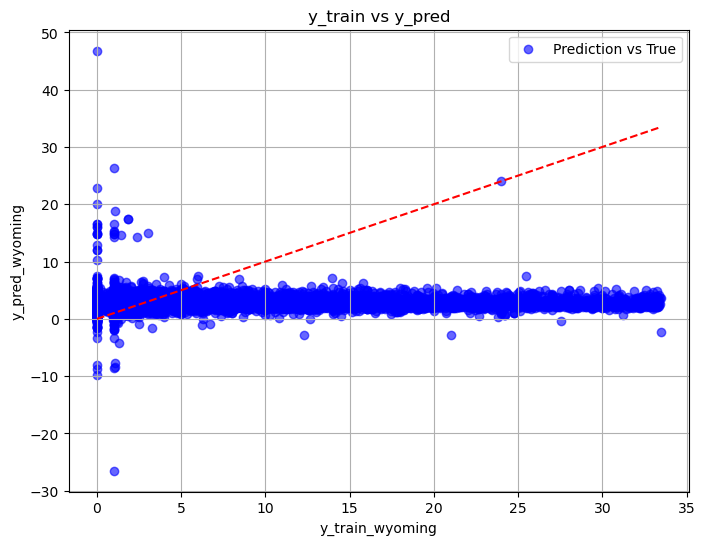

In [152]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_wyoming, y_pred_wyoming, alpha=0.6, color='blue', label='Prediction vs True')
plt.plot([min(y_train_wyoming), max(y_train_wyoming)], [min(y_train_wyoming), max(y_train_wyoming)], color='red', linestyle='--')
plt.title('y_train vs y_pred')
plt.xlabel('y_train_wyoming')
plt.ylabel('y_pred_wyoming')
plt.legend()
plt.grid(True)
plt.show()

It is noticeable that after removing the outliers, the overall model parameters improved. However, the model significantly underestimates the results and rarely predicts values above 10. Let's see how the situation changes if we switch the target to CustomersOutEstimate (i.e., the column filled with our predictions).

In [153]:
target = 'CustomersOutEstimate'
y = df_wyoming[target]

In [164]:
Q3 = np.percentile(y, 99)
Q1 = np.percentile(y, 0)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

print(f"Before: {len(y)}")
print(f"After: {len(y_no_outliers)}")


Before: 45482
After: 45315


In [165]:
X_train_wyoming, X_test_wyoming, y_train_wyoming, y_test_wyoming = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [166]:
model_TabNet_wyoming_v2 = TabNetRegressor(
    n_d=64,            
    n_a=64,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,    
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [167]:
model_TabNet_wyoming_v2.fit(
    X_train=X_train_wyoming.values,
    y_train=y_train_wyoming.values.reshape(-1,1),
    eval_set=[(X_train_wyoming.values, y_train_wyoming.values.reshape(-1,1)), 
     (X_test_wyoming.values, y_test_wyoming.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True
)

epoch 0  | loss: 7784.82695| val_0_rmse: 88.07506| val_1_rmse: 83.64131|  0:00:34s
epoch 1  | loss: 7641.67722| val_0_rmse: 86.66261| val_1_rmse: 82.28245|  0:01:17s
epoch 2  | loss: 7449.35196| val_0_rmse: 86.02856| val_1_rmse: 81.44336|  0:01:58s
epoch 3  | loss: 7428.69603| val_0_rmse: 85.18404| val_1_rmse: 80.57013|  0:02:34s
epoch 4  | loss: 7265.75118| val_0_rmse: 84.87162| val_1_rmse: 80.33918|  0:03:07s
epoch 5  | loss: 7171.44247| val_0_rmse: 84.52785| val_1_rmse: 80.04478|  0:03:36s
epoch 6  | loss: 7118.54058| val_0_rmse: 84.31534| val_1_rmse: 79.7011 |  0:04:03s
epoch 7  | loss: 6986.23165| val_0_rmse: 83.82144| val_1_rmse: 79.39158|  0:04:36s
epoch 8  | loss: 6916.13982| val_0_rmse: 83.89018| val_1_rmse: 79.33238|  0:05:09s
epoch 9  | loss: 7071.23969| val_0_rmse: 83.69383| val_1_rmse: 79.24481|  0:05:54s
epoch 10 | loss: 6885.25497| val_0_rmse: 83.6449 | val_1_rmse: 79.13445|  0:06:35s
epoch 11 | loss: 6921.39114| val_0_rmse: 83.57223| val_1_rmse: 79.10818|  0:07:05s
epoc

In [168]:
y_pred_wyoming = model_TabNet_wyoming_v2.predict(X_train_wyoming.values)

rmse = np.sqrt(mean_squared_error(y_train_wyoming, y_pred_wyoming))
mae = mean_absolute_error(y_train_wyoming, y_pred_wyoming)
r2 = r2_score(y_train_wyoming, y_pred_wyoming)

results_df = pd.DataFrame({
    'y_train_wyoming': y_train_wyoming.values.flatten(),
    'y_pred_wyoming': y_pred_wyoming.flatten()
})

print(results_df.head())
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

   y_train_wyoming  y_pred_wyoming
0         5.166667       17.158096
1         0.543630       15.634475
2        12.674334       27.280848
3        15.515848       27.628262
4         1.333333       21.789179
RMSE: 82.6754
MAE: 34.3257
R²: 0.0057


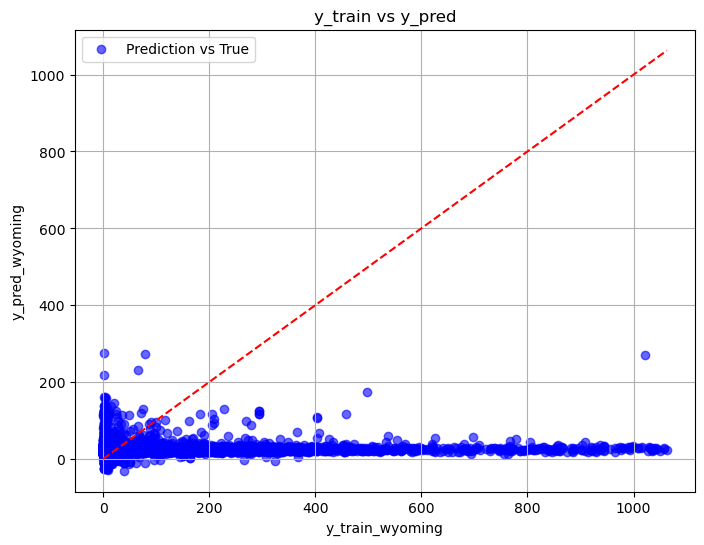

In [169]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_wyoming, y_pred_wyoming, alpha=0.6, color='blue', label='Prediction vs True')
plt.plot([min(y_train_wyoming), max(y_train_wyoming)], [min(y_train_wyoming), max(y_train_wyoming)], color='red', linestyle='--')
plt.title('y_train vs y_pred')
plt.xlabel('y_train_wyoming')
plt.ylabel('y_pred_wyoming')
plt.legend()
plt.grid(True)
plt.show()

The model tends to significantly underestimate values even after changing the target to the CustomersOutEstimate column. It is likely that not all events are recorded in the dataset related to catastrophic events, or that the causes of power outages are not strictly correlated with weather-related incidents.

In [170]:
df_folrida = df[df['StateName'] == 'Florida']

In [173]:
target = 'CustomersOut'

numeric_features = ['Tmin', 'Tmax', 'Tavg', 'Ppt', 'Lat', 'Lng']
categorical_features = ['Season', 'Region', 'Division', 'Month', 'CountyName']
event_features = [col for col in df_folrida.columns if col in event_names]

X = df_folrida[numeric_features + categorical_features + event_features]
y = df_folrida[target]

X_encoded = X.copy()
for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

In [174]:
Q3 = np.percentile(y, 90)
Q1 = np.percentile(y, 10)
IQR = Q3 - Q1
upper_bound = Q3 + 1.0 * IQR
mask = (y <= upper_bound)

y_no_outliers = y[mask]
X_no_outliers = X_encoded[mask]

print(f"Before: {len(y)}")
print(f"After: {len(y_no_outliers)}")

Before: 228359
After: 218442


In [175]:
X_train_florida, X_test_florida, y_train_florida, y_test_florida = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [176]:
model_TabNet_florida = TabNetRegressor(
    n_d=64,            
    n_a=64,
    n_steps=10,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.AdamW,    
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)

In [177]:
model_TabNet_florida.fit(
    X_train=X_train_florida.values,
    y_train=y_train_florida.values.reshape(-1,1),
    eval_set=[(X_train_florida.values, y_train_florida.values.reshape(-1,1)), 
     (X_test_florida.values, y_test_florida.values.reshape(-1,1))],
    eval_metric=["rmse"],
    max_epochs=100,
    patience=10,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=True
)

epoch 0  | loss: 3330.54324| val_0_rmse: 54.53591| val_1_rmse: 54.73665|  0:02:50s
epoch 1  | loss: 3056.39189| val_0_rmse: 55.40392| val_1_rmse: 55.55145|  0:05:51s
epoch 2  | loss: 2889.13402| val_0_rmse: 55.17335| val_1_rmse: 55.34093|  0:09:19s
epoch 3  | loss: 2765.69392| val_0_rmse: 53.58887| val_1_rmse: 53.73452|  0:13:21s
epoch 4  | loss: 2674.57049| val_0_rmse: 53.20912| val_1_rmse: 53.44238|  0:16:20s
epoch 5  | loss: 2629.82648| val_0_rmse: 52.82434| val_1_rmse: 52.97816|  0:18:57s
epoch 6  | loss: 2557.22742| val_0_rmse: 51.70224| val_1_rmse: 51.80631|  0:21:20s
epoch 7  | loss: 2529.50451| val_0_rmse: 51.09394| val_1_rmse: 51.20444|  0:23:30s
epoch 8  | loss: 2530.52263| val_0_rmse: 51.09485| val_1_rmse: 51.26196|  0:25:49s
epoch 9  | loss: 2522.51878| val_0_rmse: 51.15961| val_1_rmse: 51.27517|  0:28:04s
epoch 10 | loss: 2504.87254| val_0_rmse: 50.77402| val_1_rmse: 50.91463|  0:30:16s
epoch 11 | loss: 2497.17446| val_0_rmse: 51.44342| val_1_rmse: 51.44876|  0:32:25s
epoc

In [178]:
y_pred_florida = model_TabNet_florida.predict(X_train_florida.values)

rmse = np.sqrt(mean_squared_error(y_train_florida, y_pred_florida))
mae = mean_absolute_error(y_train_florida, y_pred_florida)
r2 = r2_score(y_train_florida, y_pred_florida)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 50.2468
MAE: 32.4147
R²: 0.0484


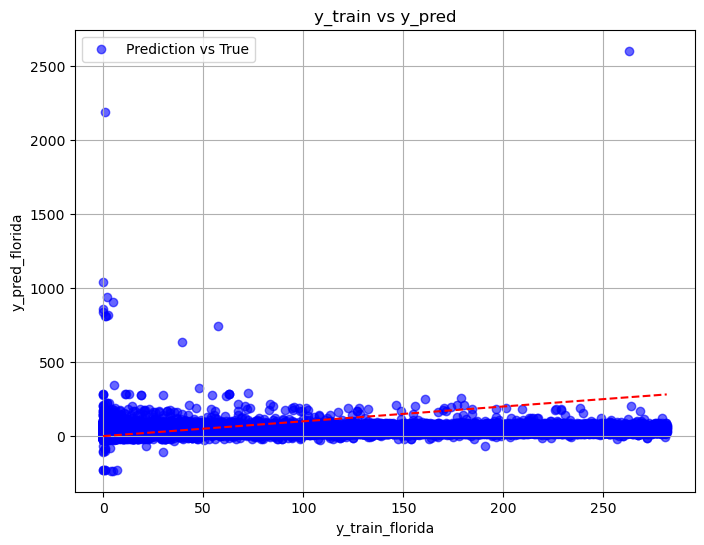

In [180]:
plt.figure(figsize=(8, 6))
plt.scatter(y_train_florida, y_pred_florida, alpha=0.6, color='blue', label='Prediction vs True')
plt.plot([min(y_train_florida), max(y_train_florida)], [min(y_train_florida), max(y_train_florida)], color='red', linestyle='--')
plt.title('y_train vs y_pred')
plt.xlabel('y_train_florida')
plt.ylabel('y_pred_florida')
plt.legend()
plt.grid(True)
plt.show()

In [182]:
model_TabNet_florida.save_model('../models/model_TabNet_florida')

Successfully saved model at ../models/model_TabNet_florida.zip


'../models/model_TabNet_florida.zip'

While we did not observe any improvement for the state of Wyoming (which was already the best predicted by the general model), we see a striking improvement for the state of Florida, which was previously the worst predicted. Now, with a model dedicated solely to Florida, the performance is even better than that for Wyoming. This leads to a simple conclusion: the model struggles to learn such highly diverse patterns when trained on all data together, but it starts to perform slightly better when we narrow the data down to smaller, more homogeneous subsets.